<a href="https://colab.research.google.com/github/jej0312/DM_TA/blob/main/7_DecisionTree(CART).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree (의사결정나무)
- TA: 전은지 (Eunji Jeon)  
- Dept. of Industrial Engineering, Yonsei Univ (Industrial Statistics Lab; ISL 산업통계연구실)
- 문의: `jej_0312_@naver.com`

- [의사결정 나무](https://heytech.tistory.com/145)
  - 불순도 (impurity)가 작은 방향, information gain이 큰 방향으로 분기 (e.g., entropy, gini index, ...)
  - [ID3](https://tyami.github.io/machine%20learning/decision-tree-2-ID3/), [C4.5](https://tyami.github.io/machine%20learning/decision-tree-3-c4_5/), CART 등
- 장점
  - 간단하고 효과적
  - interpretable/직관적 rule
  - 통계적 가정 불필요
- 단점
  - 비연속성: 분리의 경계점 근방에서는 예측 오류가 클 가능성이 있음
  - 선형성 결여: 전체적인 선형 관계 파악이 어려움
  - 비안정성: 데이터 수가 적을 경우 불안정; 과적합에 취약하므로 가지치기 필요

- based on [CART](https://tyami.github.io/machine%20learning/decision-tree-4-CART/)
  - gini index를 기준으로 불순도 평가
  - binary tree 사용
  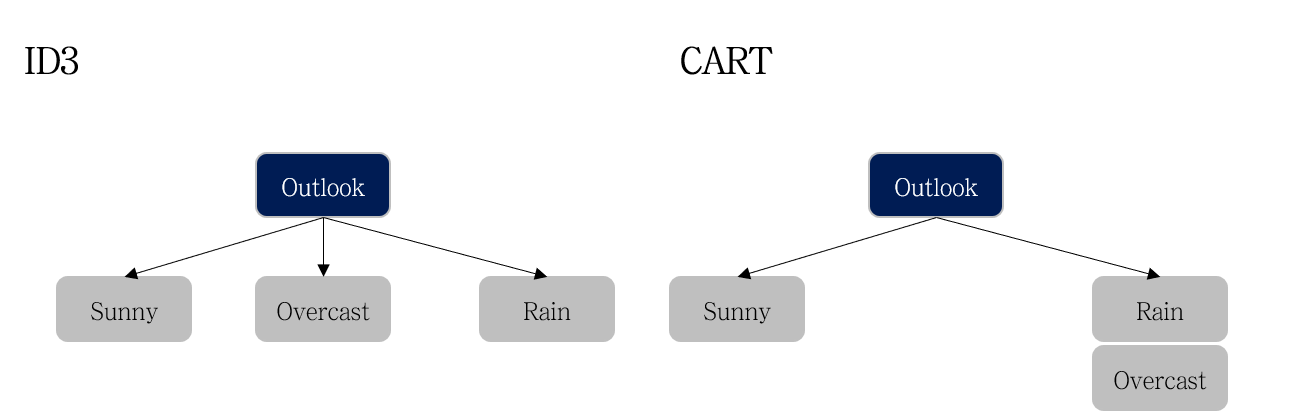

# Y: Categorical

## Step 1. Preprocessing

In [ ]:
# csv파일 불러오기
import pandas as pd
titanic_data = pd.read_csv("https://raw.githubusercontent.com/jej0312/DM_TA/main/data/titanic_data_clean.csv")

In [ ]:
titanic_data # 0: DEAD, 1: Survive

,Pclass,Sex,Fare,Survived
0,3,male,7.2500,0
1,1,female,71.2833,1
2,3,female,7.9250,1
3,1,female,53.1000,1
4,3,male,8.0500,0
...,...,...,...,...
886,2,male,13.0000,0
887,1,female,30.0000,1
888,3,female,23.4500,0
889,1,male,30.0000,1


In [ ]:
titanic_data.info()
# (0: dead, 1: survived)
# tennis_data.isnull().sum() 결측치확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Fare      891 non-null    float64
 3   Survived  891 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 28.0+ KB


In [ ]:
import pandas as pd
titanic_data['Survived'].value_counts() # Y열의 데이터 개수 확인

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
# 문자로 된 열을 더미변수로 변경해주기 (여자=0, 남자=1)
titanic_data["Sex"] = titanic_data.Sex.map({"female":0, "male":1})

In [ ]:
titanic_data

,Pclass,Sex,Fare,Survived
0,3,1,7.2500,0
1,1,0,71.2833,1
2,3,0,7.9250,1
3,1,0,53.1000,1
4,3,1,8.0500,0
...,...,...,...,...
886,2,1,13.0000,0
887,1,0,30.0000,1
888,3,0,23.4500,0
889,1,1,30.0000,1


In [ ]:
# Features와 target 나누기
t_features = titanic_data[titanic_data.columns[:-1]]
t_target = titanic_data[titanic_data.columns[-1]]

In [ ]:
# One-hot Encoding (decision tree는 비모수적 방법이므로, dummy변수를 하나 제거하는게 아니다! 살린다.)
t_features = pd.get_dummies(data = t_features, columns = ['Pclass'], prefix = 'Pclass')

In [ ]:
t_features

,Sex,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,7.2500,0,0,1
1,0,71.2833,1,0,0
2,0,7.9250,0,0,1
3,0,53.1000,1,0,0
4,1,8.0500,0,0,1
...,...,...,...,...,...
886,1,13.0000,0,1,0
887,0,30.0000,1,0,0
888,0,23.4500,0,0,1
889,1,30.0000,1,0,0


In [ ]:
# train: test = 8:2 분리
from sklearn.model_selection import train_test_split
train_features, test_features , train_target, test_target = train_test_split(
    t_features, t_target, test_size = 0.2, random_state = 2021, stratify=t_target)

In [ ]:
print(len(train_features))
print(len(train_target))

print(len(test_features))
print(len(test_target))

712
712
179
179


In [ ]:
import pandas as pd
pd.DataFrame(train_target)['Survived'].value_counts() # Y열의 데이터 개수 확인

0    439
1    273
Name: Survived, dtype: int64

- class 불균형이 심한 경우 샘플링 진행

In [ ]:
# Under Sampling: Y값을 각각 {0, 1} 239명씩
## sampling하기 전에 shuffling을 해주기(행 순서 섞기)
import sklearn
x_shuffled = sklearn.utils.shuffle(train_features, random_state=312)
y_shuffled = sklearn.utils.shuffle(train_target, random_state=312)

import imblearn
from imblearn.under_sampling import RandomUnderSampler
train_features_us, train_target_us = RandomUnderSampler(random_state=312).fit_resample(x_shuffled, y_shuffled)

In [ ]:
import pandas as pd
pd.DataFrame(train_target_us)['Survived'].value_counts() # Y열의 데이터 개수 확인: total 546명

0    273
1    273
Name: Survived, dtype: int64

## Step 2. Decision Tree Modeling
- gini: 엔트로피와 같은 불순도 (Impurity) 지표
  - 분류가 잘 될 때 낮은 값
  - CART 알고리즘에서는 모든 조합에 대해 Gini index를 계산한 후, Gini index가 가장 낮은 지표를 찾아 분기
- entropy (uncertainty)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state = 312)
# criterion = 'gini' 또는 'entropy' (default='gini')
# max_depth = None (default)
# min_samples_leaf = 1 (default)
# min_samples_split = None (default)
# random_state = None (default)

tree_fit = tree.fit(train_features_us, train_target_us)

In [ ]:
tree_fit

DecisionTreeClassifier(random_state=312)

In [ ]:
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image # CART Tree 그림
import os

In [ ]:
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [ ]:
import numpy as np
feature_names = train_features_us.columns.tolist()
target_name = np.array(['Dead', 'Survive'])

In [ ]:
dot_data = export_graphviz(tree,
                          filled = True,
                          rounded = True,
                          class_names = target_name,
                          feature_names = feature_names,
                          out_file = None)

graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png') #Tree 이미지를 저장

True

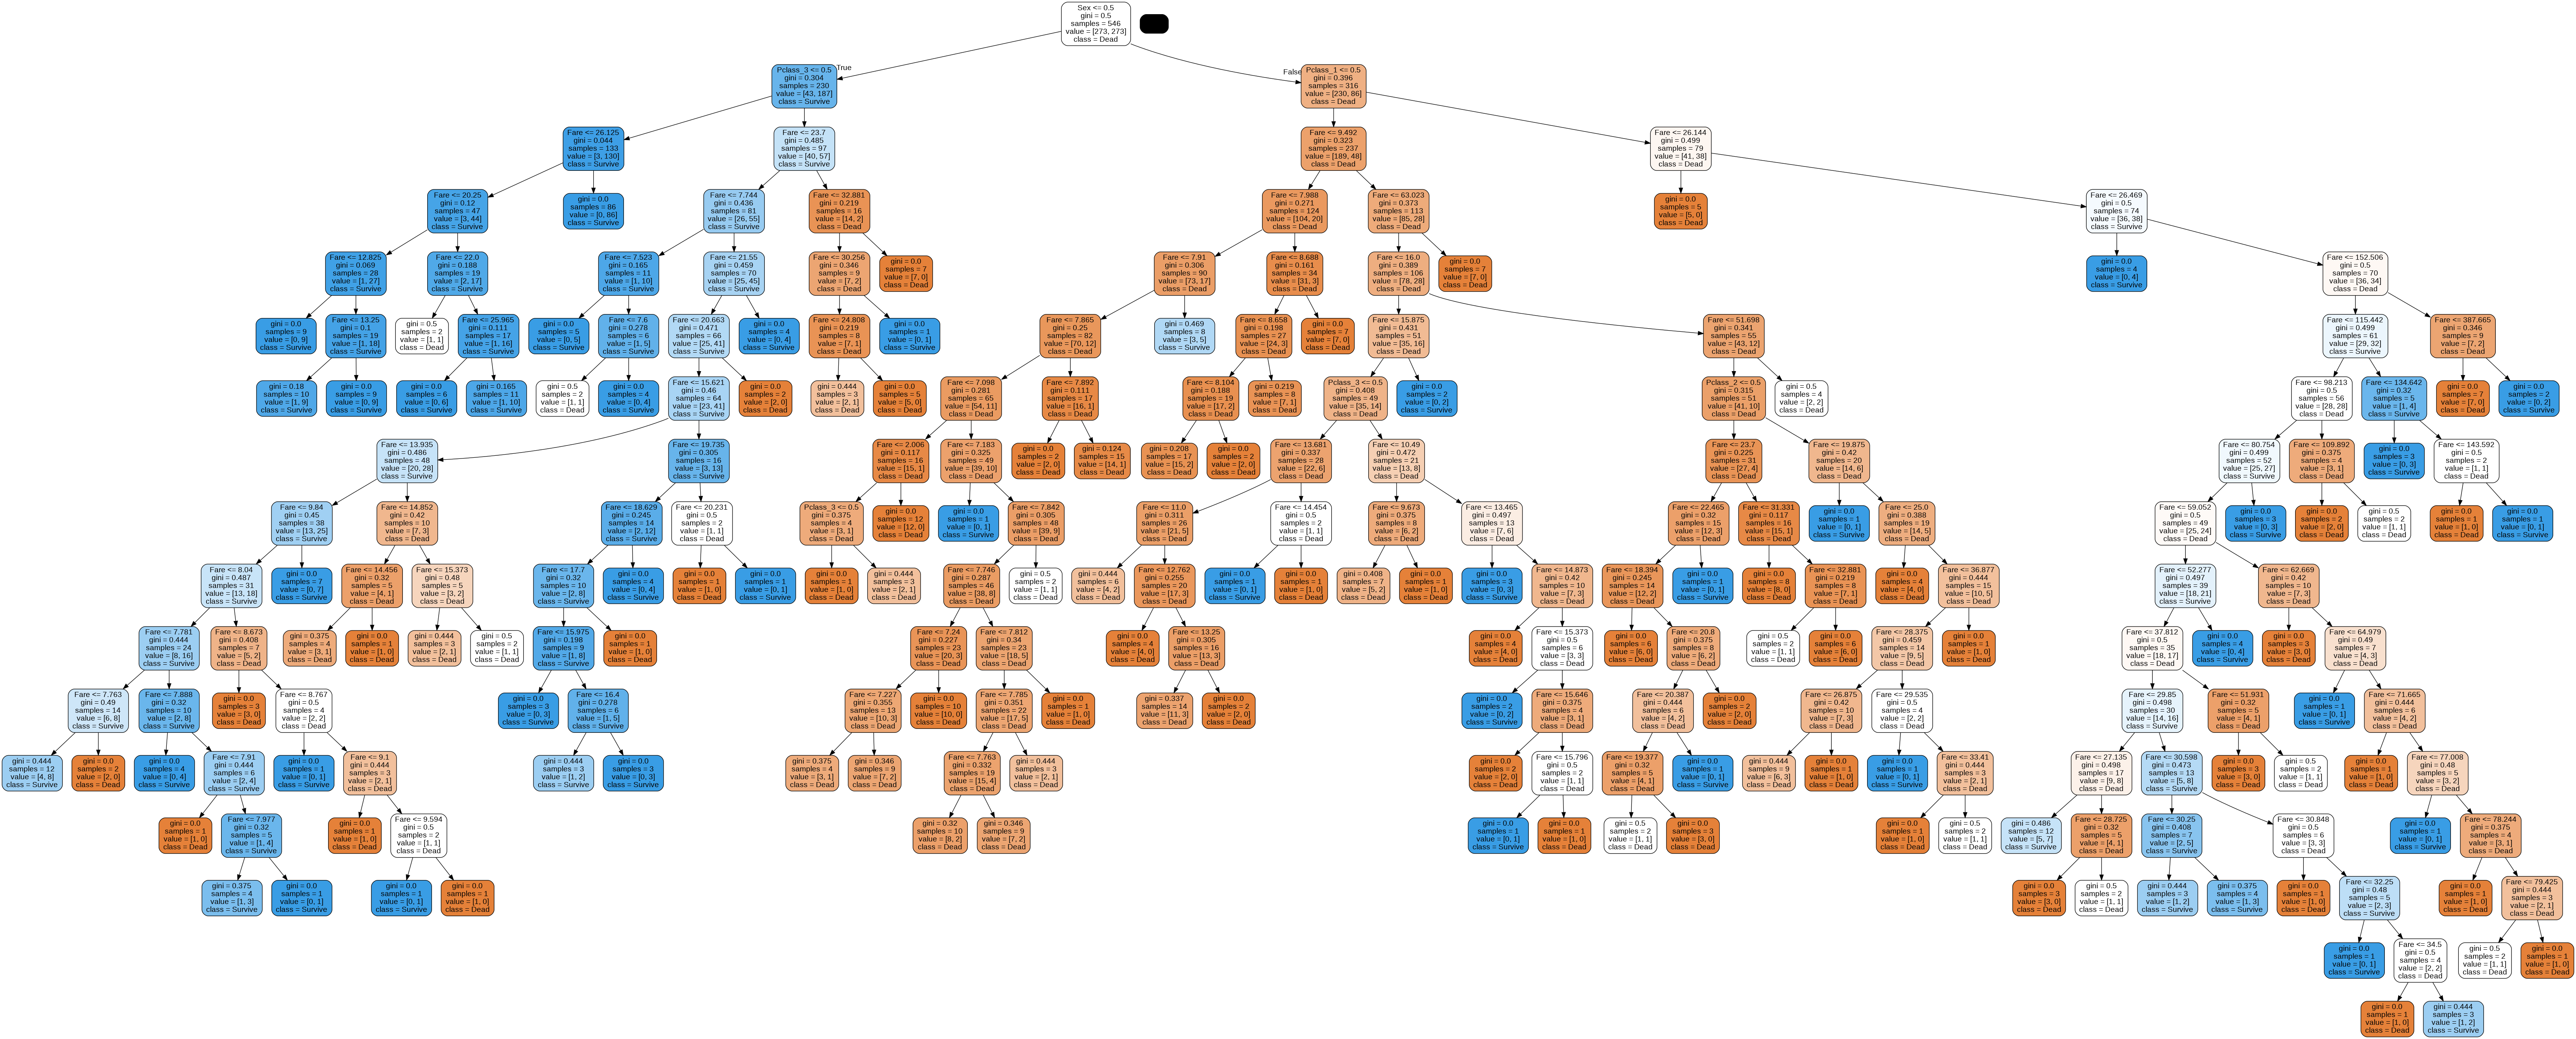

In [ ]:
dt_graph = pydotplus.graph_from_dot_data(dot_data)
Image(dt_graph.create_png())

In [ ]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator = tree,
                       X=train_features_us,
                       y=train_target_us,
                       scoring = ['accuracy'],
                       cv=10,
                       n_jobs= -1,
                       return_train_score=False)

print('CV accuracy: %s' % scores['test_accuracy'])
print('CV aacuracy(Mean): %.3f (std: %.3f)' % (np.mean(scores['test_accuracy']),
                                     np.std(scores['test_accuracy'])))

CV accuracy: [0.67272727 0.81818182 0.8        0.8        0.76363636 0.89090909
 0.7037037  0.77777778 0.81481481 0.75925926]
CV aacuracy(Mean): 0.780 (std: 0.058)


In [ ]:
y_pred = tree.predict(test_features)

In [ ]:
y_pred

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

confmat = pd.DataFrame(confusion_matrix(test_target, y_pred),
                      index=['True[0]', 'True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])

confmat

,Predict[0],Predict[1]
True[0],91,19
True[1],18,51


In [ ]:
from sklearn.metrics import classification_report

print('Classification Report')
print(classification_report(test_target, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       110
           1       0.73      0.74      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('정확도 accuracy: %.3f' % accuracy_score(test_target, y_pred))
print('정밀도 precision: %.3f' % precision_score(y_true= test_target, y_pred=y_pred))
print('재현율 recall: %.3f' % recall_score(y_true=test_target, y_pred=y_pred))
print('F1-score: %.3f' % f1_score(y_true=test_target, y_pred=y_pred))
print('AUC: %.3f' % roc_auc_score(test_target, y_pred))

정확도 accuracy: 0.793
정밀도 precision: 0.729
재현율 recall: 0.739
F1-score: 0.734
AUC: 0.783


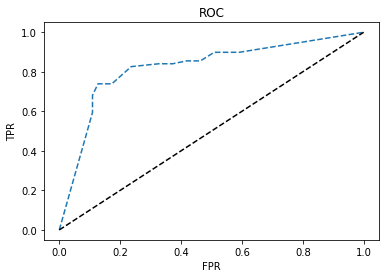

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve( test_target, tree.predict_proba(test_features)[:, 1] )

plt.plot(fpr, tpr, '--', label = 'Decision Tree')
plt.plot([0,1], [0,1], 'k--', label='random guess')
plt.plot([fpr],[tpr],'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

## Step 3. Optimization

In [ ]:
from sklearn.pipeline import make_pipeline
pipe_tree = make_pipeline(DecisionTreeClassifier(random_state=312)) # default model로 시작
# pipeline은 hyper-parameter 값을 바꾸면서 여러 모델을 사용 가능.

In [ ]:
pipe_tree.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'decisiontreeclassifier', 'decisiontreeclassifier__ccp_alpha', 'decisiontreeclassifier__class_weight', 'decisiontreeclassifier__criterion', 'decisiontreeclassifier__max_depth', 'decisiontreeclassifier__max_features', 'decisiontreeclassifier__max_leaf_nodes', 'decisiontreeclassifier__min_impurity_decrease', 'decisiontreeclassifier__min_samples_leaf', 'decisiontreeclassifier__min_samples_split', 'decisiontreeclassifier__min_weight_fraction_leaf', 'decisiontreeclassifier__random_state', 'decisiontreeclassifier__splitter'])

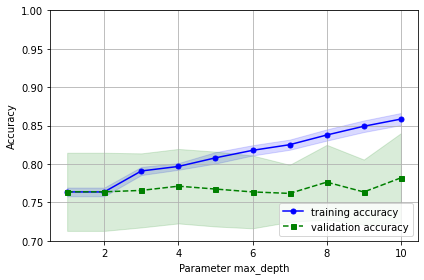

In [ ]:
from sklearn.model_selection import validation_curve

param_range = [1,2,3,4,5,6,7,8,9,10] # max_depth 범위 설정
train_scores, validation_scores = validation_curve(estimator = pipe_tree, #기본모형 선택
                                                   X = train_features_us,
                                                   y = train_target_us,
                                                   param_name = 'decisiontreeclassifier__max_depth', #pipe_tree.get_params().keys()에서
                                                   param_range=param_range,
                                                   scoring="accuracy",
                                                   cv=10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
validation_mean = np.mean(validation_scores, axis = 1)
validation_std = np.std(validation_scores, axis = 1)

plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='training accuracy')
plt.fill_between(param_range, 
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue')
plt.plot(param_range, validation_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(param_range,
                validation_mean + validation_std,
                validation_mean - validation_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of max_depth')
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.00]) # 보고싶은 구간 설정
plt.tight_layout()
plt.show()

# train accuracy와 validation accuracy가 모두 적절한 성능 & 오버피팅이 발생하기 전까지인 max_dept = 4 선택

## Step 4. Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_range1 = [1,2,3,4,5,6,7,8,9,10]
param_range2 = [10, 20, 30, 40, 50]
param_range3 = ['gini', 'entropy']

param_grid = [{'decisiontreeclassifier__max_depth': param_range1,
              'decisiontreeclassifier__min_samples_leaf': param_range2,
              'decisiontreeclassifier__criterion': param_range3}]

gs = GridSearchCV(estimator = pipe_tree,
                 param_grid = param_grid, # 찾고자하는 파라미터. dictionary 형식
                 scoring = 'accuracy', #  Classification일때  'accuracy','f1', Regression 일때 'neg_mean_squared_error','r2' 등
                 cv=10,
                 n_jobs= -1) # 병렬 처리; -1은 전부를 의미

gs = gs.fit(train_features_us, train_target_us)

print(gs.best_score_)
print(gs.best_params_)

0.774949494949495
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 10}


In [ ]:
# 최적의 모델 선택
best_tree = gs.best_estimator_
best_tree.fit(train_features_us, train_target_us)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        min_samples_leaf=10,
                                        random_state=312))])

In [ ]:
best_tree_for_graph = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=10, random_state = 2021)

In [ ]:
best_tree_for_graph.fit(train_features_us, train_target_us)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=2021)

In [ ]:
y_pred = best_tree.predict(test_features)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(test_target, y_pred),
                      index=['True[0]', 'True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],96,14
True[1],23,46


In [ ]:
from sklearn.metrics import classification_report

print('Classification Report')
print(classification_report(test_target, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       110
           1       0.77      0.67      0.71        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('정확도 accuracy: %.3f' % accuracy_score(test_target, y_pred))
print('정밀도 precision: %.3f' % precision_score(y_true= test_target, y_pred=y_pred))
print('재현율 recall: %.3f' % recall_score(y_true=test_target, y_pred=y_pred))
print('F1-score: %.3f' % f1_score(y_true=test_target, y_pred=y_pred))
print('AUC: %.3f' % roc_auc_score(test_target, y_pred))

정확도 accuracy: 0.793
정밀도 precision: 0.767
재현율 recall: 0.667
F1-score: 0.713
AUC: 0.770


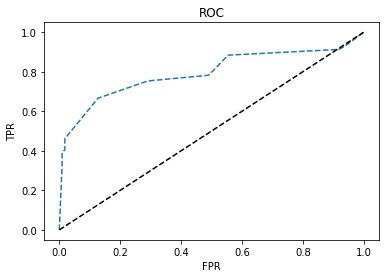

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve( test_target, best_tree.predict_proba(test_features)[:, 1] )

plt.plot(fpr, tpr, '--', label = 'Decision Tree')
plt.plot([0,1], [0,1], 'k--', label='random guess')
plt.plot([fpr],[tpr],'r-', ms=10)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

In [ ]:
import numpy as np
feature_names = train_features_us.columns.tolist()
target_name = np.array(['Dead', 'Survive'])

In [ ]:
dot_data_best = export_graphviz(best_tree_for_graph,
                          filled = True,
                          rounded = True,
                          class_names = target_name,
                          feature_names = feature_names,
                          out_file = None)

graph_best = graph_from_dot_data(dot_data_best)
graph.write_png('tree_best.png') #Tree 이미지를 저장

True

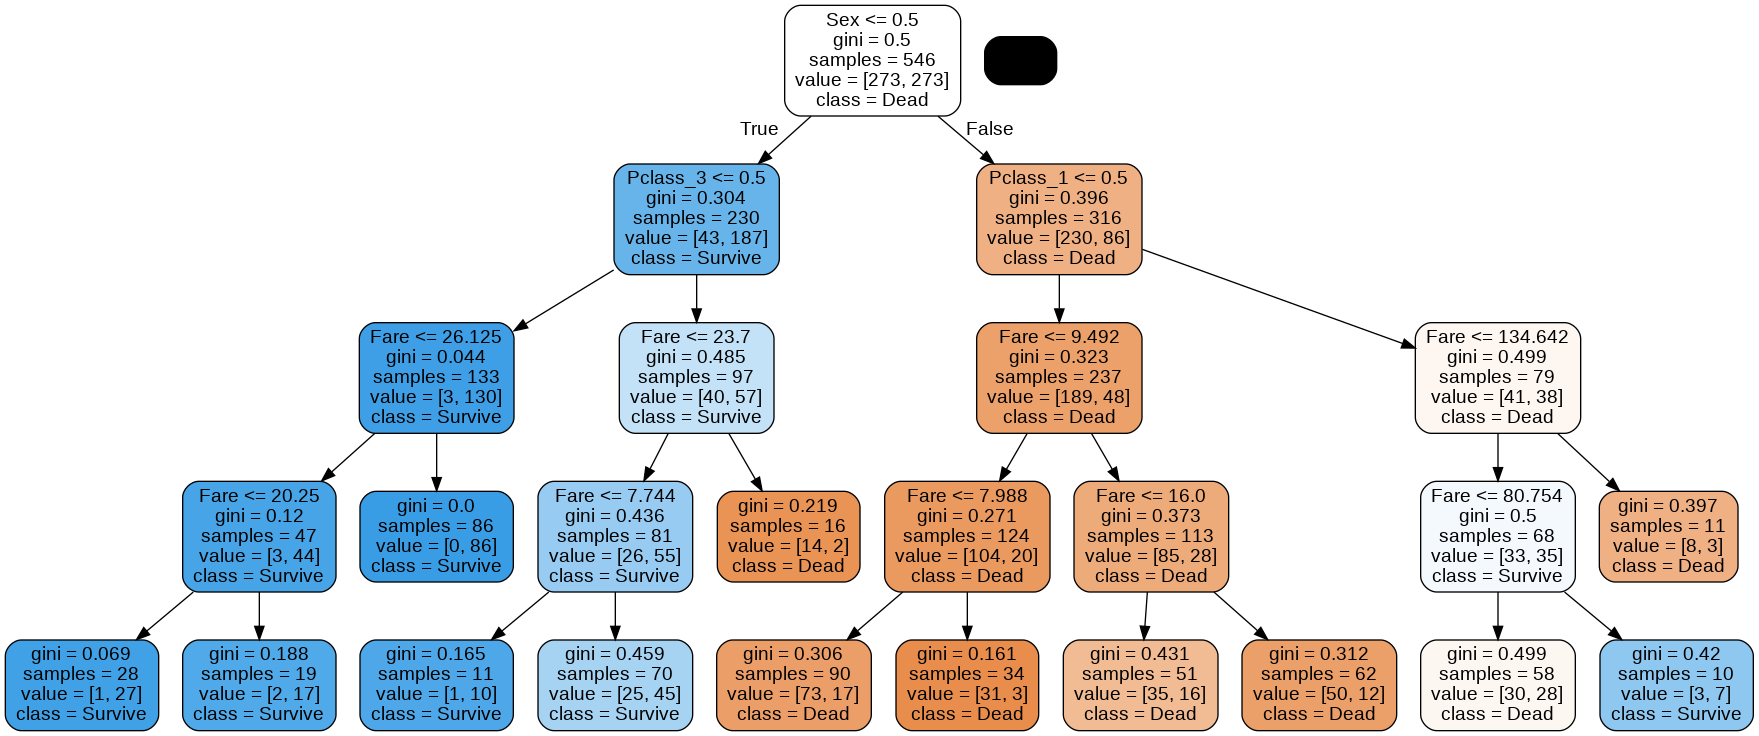

In [ ]:
dt_graph_best = pydotplus.graph_from_dot_data(dot_data_best)
Image(dt_graph_best.create_png())

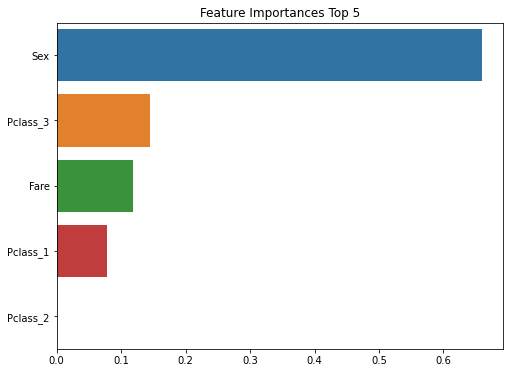

In [ ]:
# Feature Importance

import seaborn as sns
feature_importance_values = best_tree_for_graph.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=train_features_us.columns)
feature_top5 = feature_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [ ]:
feature_importances.sort_values(ascending=False)

Sex         0.659298
Pclass_3    0.144295
Fare        0.118618
Pclass_1    0.077789
Pclass_2    0.000000
dtype: float64

# Y: Continuous

In [ ]:
# Boston Housing dataset
# data source: https://www.kaggle.com/kyasar/boston-housing
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jej0312/DM_TA/main/data/boston_housing.csv")

df

# Features
# crim: Per capita crims rate by town
# chas: Charles River dummy variable (1: tract bounds river, 0: otherwise)
# tax: full-value property-tax rate per $10,000
# lstat: % lower of the population

# Target
# medv: Median value of owner-occupied homes in $1000's

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [ ]:
data = df[['crim', 'chas', 'tax', 'lstat', 'medv']]

In [ ]:
data

,crim,chas,tax,lstat,medv
0,0.00632,0,296.0,4.98,24.0
1,0.02731,0,242.0,9.14,21.6
2,0.02729,0,242.0,4.03,34.7
3,0.03237,0,222.0,2.94,33.4
4,0.06905,0,222.0,5.33,36.2
...,...,...,...,...,...
501,0.06263,0,273.0,9.67,22.4
502,0.04527,0,273.0,9.08,20.6
503,0.06076,0,273.0,5.64,23.9
504,0.10959,0,273.0,6.48,22.0


In [ ]:
# Features와 target 나누기
t_features = data[data.columns[:-1]]
t_target = data[data.columns[-1]]

In [ ]:
t_features

,crim,chas,tax,lstat
0,0.00632,0,296.0,4.98
1,0.02731,0,242.0,9.14
2,0.02729,0,242.0,4.03
3,0.03237,0,222.0,2.94
4,0.06905,0,222.0,5.33
...,...,...,...,...
501,0.06263,0,273.0,9.67
502,0.04527,0,273.0,9.08
503,0.06076,0,273.0,5.64
504,0.10959,0,273.0,6.48


In [ ]:
t_features

,crim,chas,tax,lstat
0,0.00632,0,296.0,4.98
1,0.02731,0,242.0,9.14
2,0.02729,0,242.0,4.03
3,0.03237,0,222.0,2.94
4,0.06905,0,222.0,5.33
...,...,...,...,...
501,0.06263,0,273.0,9.67
502,0.04527,0,273.0,9.08
503,0.06076,0,273.0,5.64
504,0.10959,0,273.0,6.48


In [ ]:
# train: test = 8:2 분리
from sklearn.model_selection import train_test_split
train_features, test_features , train_target, test_target = train_test_split(
    t_features, t_target, test_size = 0.2, random_state = 312)

In [ ]:
print(len(train_features))
print(len(train_target))

print(len(test_features))
print(len(test_target))

404
404
102
102


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


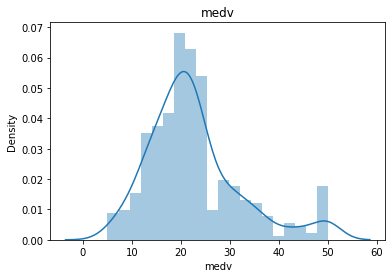

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(pd.DataFrame(train_target).loc[pd.DataFrame(train_target)['medv'].notnull(), 'medv'])
plt.title('medv')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor
'''
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
criterion = 'mse' 또는 'mae' (default='mse')
max_depth = None (default)
min_samples_leaf = 1 (default)
min_samples_split = None (default)
'''
tree = DecisionTreeRegressor(random_state = 312)

tree_fit = tree.fit(train_features, train_target)

In [ ]:
tree_fit

DecisionTreeRegressor(random_state=312)

In [ ]:
from sklearn.pipeline import make_pipeline
pipe_tree = make_pipeline(DecisionTreeRegressor(random_state=312)) # default model로 시작
# hyper-parameter 값을 바꾸면서 여러 모델 사용

In [ ]:
pipe_tree.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'decisiontreeregressor', 'decisiontreeregressor__ccp_alpha', 'decisiontreeregressor__criterion', 'decisiontreeregressor__max_depth', 'decisiontreeregressor__max_features', 'decisiontreeregressor__max_leaf_nodes', 'decisiontreeregressor__min_impurity_decrease', 'decisiontreeregressor__min_samples_leaf', 'decisiontreeregressor__min_samples_split', 'decisiontreeregressor__min_weight_fraction_leaf', 'decisiontreeregressor__random_state', 'decisiontreeregressor__splitter'])

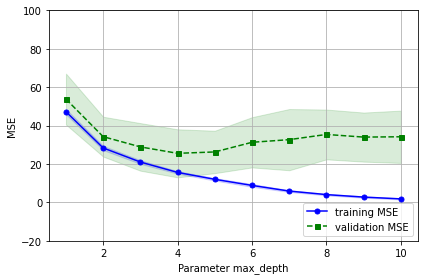

In [ ]:
from sklearn.model_selection import validation_curve
import numpy as np

param_range = [1,2,3,4,5,6,7,8,9,10] # max_depth 범위 설정
train_scores, validation_scores = validation_curve(estimator = pipe_tree, #기본모형 선택
                                                   X = train_features,
                                                   y = train_target,
                                                   param_name = 'decisiontreeregressor__max_depth', #pipe_tree.get_params().keys()에서 비교 대상 선정
                                                   param_range=param_range,
                                                   scoring= "neg_mean_squared_error",
                                                   cv=10)

train_mean = (np.mean(-train_scores, axis = 1))
train_std = np.std(-train_scores, axis = 1)
validation_mean = np.mean(-validation_scores, axis = 1)
validation_std = np.std(-validation_scores, axis = 1)

plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='training MSE')
plt.fill_between(param_range, 
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue')
plt.plot(param_range, validation_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation MSE')
plt.fill_between(param_range,
                validation_mean + validation_std,
                validation_mean - validation_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of max_depth')
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('MSE')
plt.ylim([-20.00, 100.00])
plt.tight_layout()
plt.show()

# train accuracy와 validation accuracy가 모두 적절한 성능 & 오버피팅 발생 직전인 max_dept = 4 선택

In [ ]:
from sklearn.model_selection import GridSearchCV
param_range1 = [1,2,3,4,5,6,7,8,9,10]
param_range2 = [10, 20, 30, 40, 50]
param_range3 = ['mse', 'mae'] # 'explained_variance' 등도 가능

param_grid = [{'decisiontreeregressor__max_depth': param_range1,
              'decisiontreeregressor__min_samples_leaf': param_range2,
              'decisiontreeregressor__criterion': param_range3}]

gs = GridSearchCV(estimator = pipe_tree,
                 param_grid = param_grid, # 찾고자하는 파라미터. dictionary 형식
                 scoring = 'neg_mean_squared_error', # Regression 일때 'neg_mean_squared_error','r2' 등
                 cv=10,
                 n_jobs= -1)

gs = gs.fit(train_features, train_target)

print(-gs.best_score_)
print(gs.best_params_)

28.454197812256172
{'decisiontreeregressor__criterion': 'mse', 'decisiontreeregressor__max_depth': 4, 'decisiontreeregressor__min_samples_leaf': 20}


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


In [ ]:
best_tree = gs.best_estimator_ # 최적의 파라미터로 모델 생성
best_tree.fit(train_features, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(criterion='mse', max_depth=4,
                                       min_samples_leaf=20,
                                       random_state=312))])

In [ ]:
best_tree_for_graph = DecisionTreeRegressor(criterion='mse', max_depth=4, min_samples_leaf=20, random_state = 312)
best_tree_for_graph.fit(train_features, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


DecisionTreeRegressor(criterion='mse', max_depth=4, min_samples_leaf=20,
                      random_state=312)

In [ ]:
y_pred = best_tree.predict(test_features)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
print('R squared: %.3f' % r2_score(test_target, y_pred))
print('MSE: %.3f' % mean_squared_error(test_target,y_pred))

# 참고: https://scikit-learn.org/stable/modules/classes.html?highlight=sklearn%20metrics#module-sklearn.metrics

R squared: 0.552
MSE: 28.644


In [ ]:
import numpy as np
feature_names = train_features.columns.tolist()
target_name = np.array(['medv'])

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot_data_best = export_graphviz(best_tree_for_graph,
                          filled = True,
                          rounded = True,
                          class_names = target_name,
                          feature_names = feature_names,
                          out_file = None)

graph_best = graph_from_dot_data(dot_data_best)
graph_best.write_png('tree_best_regression.png') #Tree 이미지를 저장

True

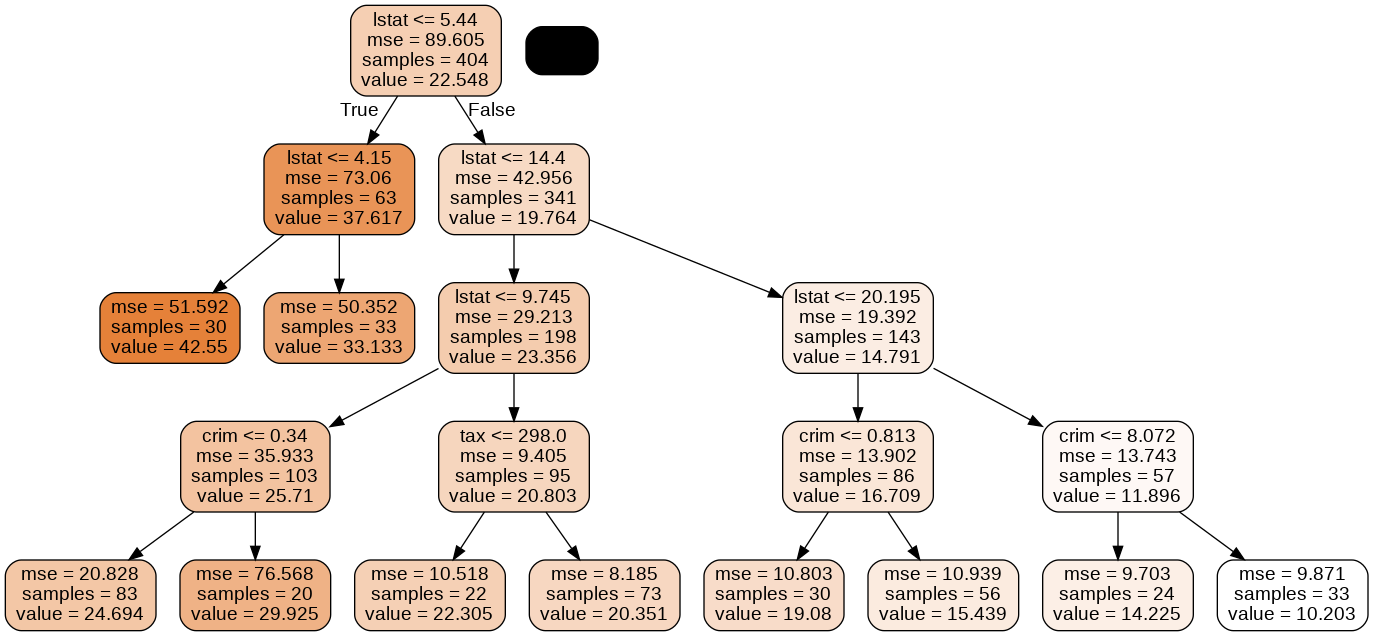

In [ ]:
dt_graph_best = pydotplus.graph_from_dot_data(dot_data_best)
Image(dt_graph_best.create_png())

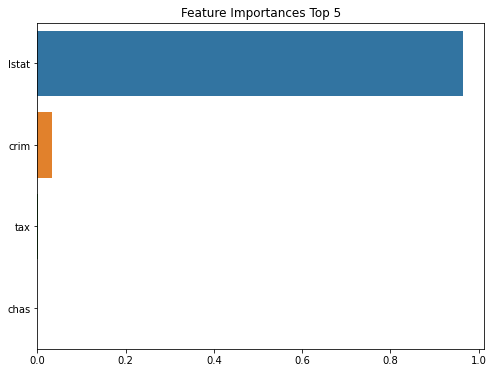

In [ ]:
# Feature Importance

import seaborn as sns
feature_importance_values = best_tree_for_graph.feature_importances_
feature_importances = pd.Series(feature_importance_values, index=train_features.columns)
feature_top5 = feature_importances.sort_values(ascending=False)[:5]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 5')
sns.barplot(x=feature_top5, y=feature_top5.index)
plt.show()

In [ ]:
feature_importances.sort_values(ascending=False)

lstat    0.963905
crim     0.033740
tax      0.002355
chas     0.000000
dtype: float64